In [2]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import re
import json
import requests
from bs4 import BeautifulSoup
import datetime
from pprint import pprint

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# load wrangle.csv file
df = pd.read_csv('wrangle.csv', index_col=0)
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000


In [5]:
# add revenue column
# change unit to 1 million
df['revenue'] = df.gross - df.budget
df.budget = df['budget'] / 1000000
df.gross = df['gross'] / 1000000
df.revenue = df['revenue'] / 1000000


In [6]:
# remove gross column
df = df.drop('gross', axis=1)

### Add month column

In [7]:
import json
with open('scraping/imdb_month.json', 'r') as f:
    imdb_month = json.load(f)

In [8]:
# use link to put month into month column
df['month'] = df.movie_imdb_link.map(imdb_month)

In [9]:
df.loc[:, 'month'] = df['month'].str[0]

In [10]:
# remove all NaNs from month list
df = df.dropna(axis=0)
len(df[df.month.isnull()])

0

In [11]:
df.loc[:, 'month'] =df.loc[:, 'month'].str.replace('\d+ ', '')

In [12]:
# change month to datetime format
df.loc[:, 'month'] = pd.to_datetime(df['month'], format='%B', errors='coerce').dt.month

In [13]:
print "Movie data now has {} observations".format(len(df))

Movie data now has 3569 observations


In [14]:
# reset index to a sequential number
df = df.reset_index(drop=True)

### Drop budget column

In [15]:
df = df.drop('budget', axis=1)

**Subgroup budget by positive or negative revenue**
df['budget_group'] = np.NaN
for i in range(0, 3569):
    if df.loc[i, 'revenue'] > 0:
        df.loc[i, 'budget_group'] = 1
    else:
        df.loc[i, 'budget_group'] = 0

### Transform color into numerics

In [16]:
for i in range(0, 3569):
    if df.loc[i, 'color'] == 'Color':
        df.loc[i, 'color'] = 1
    else:
        df.loc[i, 'color'] = 0

### Replace director_name to their frequency

In [17]:
director_freq = Counter(df.director_name)

In [18]:
df.director_name = df.director_name.map(director_freq)

### Replace actor_name to their frequency

In [29]:
actor = ['actor_1_name', 'actor_2_name', 'actor_3_name']
for i in actor:
    freq = Counter(df[i])
    df[i] = df[i].map(freq)

### Transform genres column to dummies

In [19]:
s = df['genres'].str.split('|', expand=False)
dummy = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
dummy = dummy.astype('float')

In [20]:
df = pd.concat([df, dummy], axis=1)

In [21]:
df = df.drop('genres', axis=1)

### Remove unrelated columns

In [22]:
df= df.drop(['content_rating', 'aspect_ratio', 'plot_keywords', 'movie_imdb_link'], axis=1)

### Change country and language columns to dummies

In [23]:
for i in range(0, 3569):
    if df.loc[i, 'country'] == 'USA':
        df.loc[i, 'country'] = 0
    else:
        df.loc[i, 'country'] = 1

In [24]:
for i in range(0, 3569):
    if df.loc[i, 'language'] == 'English':
        df.loc[i, 'language'] = 0
    else:
        df.loc[i, 'language'] = 1

country_language = ['country', 'language']
for i in country_language:
    freq = Counter(df[i])
    df[i] = df[i].map(freq)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

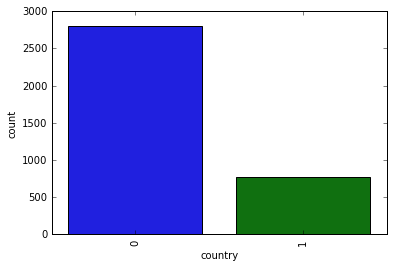

In [25]:
sns.countplot(x='country', data=df)
plt.xticks(rotation=90)

### Set index to be movie_title

In [26]:
df = df.set_index(df.movie_title)

In [27]:
df = df.drop('movie_title', axis=1)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3569 entries, Avatar to My Date with Drew
Data columns (total 44 columns):
color                        3569 non-null int64
director_name                3569 non-null int64
num_critic_for_reviews       3569 non-null float64
duration                     3569 non-null float64
director_facebook_likes      3569 non-null float64
actor_3_facebook_likes       3569 non-null float64
actor_2_name                 3569 non-null int64
actor_1_facebook_likes       3569 non-null float64
actor_1_name                 3569 non-null int64
num_voted_users              3569 non-null int64
cast_total_facebook_likes    3569 non-null int64
actor_3_name                 3569 non-null int64
facenumber_in_poster         3569 non-null float64
num_user_for_reviews         3569 non-null float64
language                     3569 non-null int64
country                      3569 non-null int64
title_year                   3569 non-null float64
actor_2_facebook_likes       35

### Check correlation matrix
* actor_1_facebook_likes & cast_total_facebook_likes columns have ~ 0.8 correlation
* drop actor_1_facebook_likes column

In [31]:
cor = df.corr()

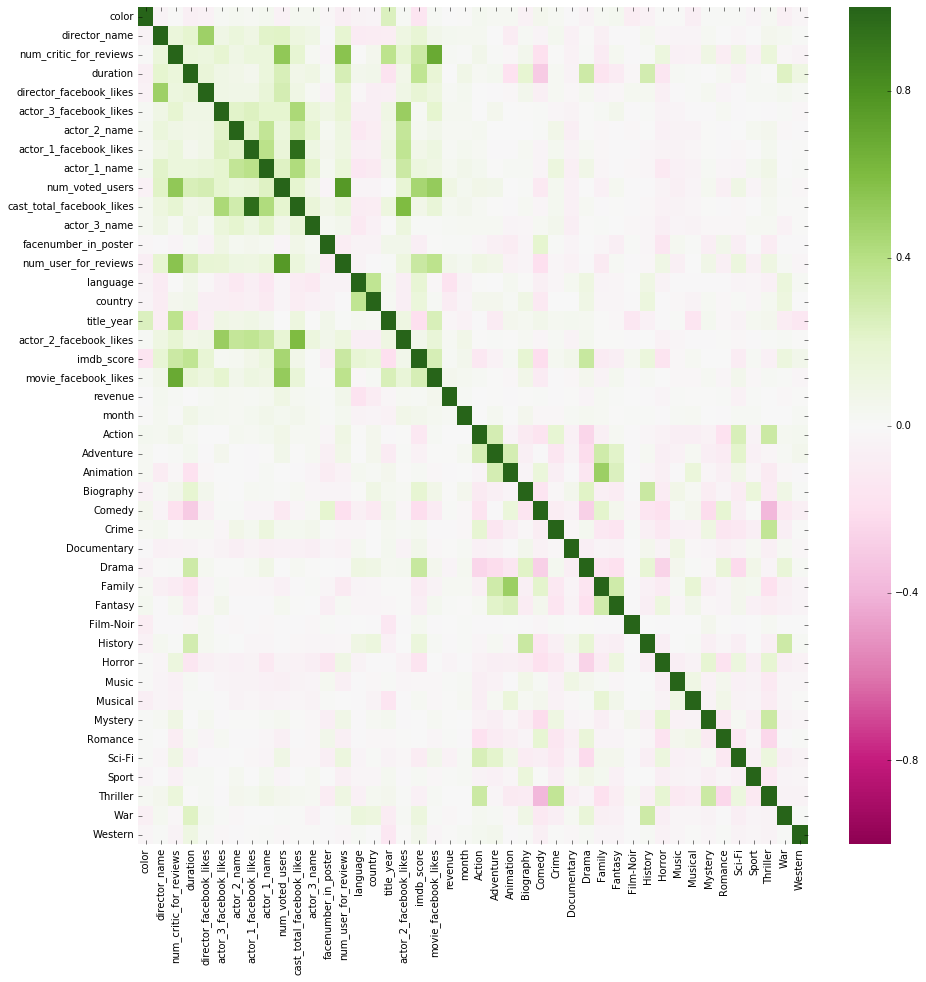

In [32]:
plt.figure(figsize=(15, 15))
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, cmap='PiYG', vmax=1, vmin=-1) 
# Put annotation in the heatmap by two parameters: annot=True, annot_kws={"size": 10}

In [33]:
# check the highest coreelation between two features
for i in cor.columns:
    for j in cor.index:
        if (cor.loc[j, i] > 0.8) & (cor.loc[j, i] < 1):
            print i + ' / ' + j

actor_1_facebook_likes / cast_total_facebook_likes
cast_total_facebook_likes / actor_1_facebook_likes


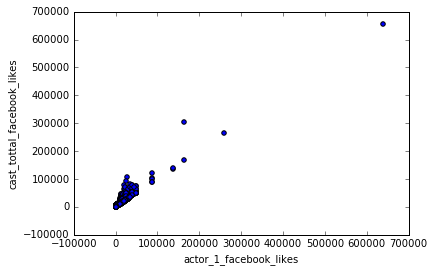

In [34]:
plt.scatter(x=df.actor_1_facebook_likes, y=df.cast_total_facebook_likes)
plt.xlabel('actor_1_facebook_likes')
plt.ylabel('cast_tottal_facebook_likes')

In [35]:
df = df.drop('actor_1_facebook_likes', axis=1)

### Seaborn pairplot
* revenue's distribution is too skewed
 * set revenue > -400

In [ ]:
sns.pairplot(df.iloc[:, 0:22])
sns.set(font_scale=3)

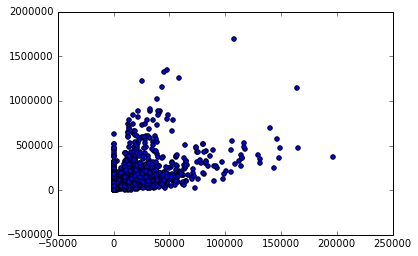

In [36]:
plt.scatter(x='movie_facebook_likes', y='num_voted_users', data=df)

In [37]:
df = df[(df.revenue > -400)]

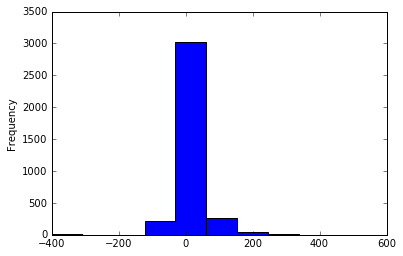

In [38]:
df['revenue'].plot(kind='hist')

### save df to .csv file

In [39]:
df.to_csv('ml.csv')

# --------------------------

# Data prep for classification

In [110]:
df_logit = df.copy()
df_logit = df_logit.reset_index(drop=True)

In [111]:
for i in range(0, 3559):
    if df_logit.loc[i, 'revenue'] > 0:
        df_logit.loc[i, 'revenue'] = 1
    else:
        df_logit.loc[i, 'revenue'] = 0

In [112]:
# Check dataframe 5 rows and 21 cols
df_logit.iloc[:5, :21]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_name,num_voted_users,cast_total_facebook_likes,...,facenumber_in_poster,num_user_for_reviews,language,country,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,revenue,month
0,1,4,723.0,178.0,0.0,855.0,3,3,886204,4834,...,0.0,3054.0,0,0,2009.0,936.0,7.9,33000,1.0,12
1,1,3,302.0,169.0,563.0,1000.0,1,28,471220,48350,...,0.0,1238.0,0,0,2007.0,5000.0,7.1,0,1.0,5
2,1,8,602.0,148.0,0.0,161.0,2,2,275868,11700,...,1.0,994.0,0,1,2015.0,393.0,6.8,85000,0.0,11
3,1,4,813.0,164.0,22000.0,23000.0,4,8,1144337,106759,...,0.0,2701.0,0,0,2012.0,23000.0,8.5,164000,1.0,7
4,1,1,462.0,132.0,475.0,530.0,3,2,212204,1873,...,1.0,738.0,0,0,2012.0,632.0,6.6,24000,0.0,3


In [113]:
X = df_logit.drop('revenue', axis=1)
y = df_logit['revenue']

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [115]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# 1. Logistic regression

In [46]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=100, random_state=1)

In [47]:
logit.fit(X_train_std, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
y_pred = logit.predict(X_test_std)

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.72097378277153557

### look for the best hyperparameter C for logistic regression

In [210]:
params, score = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    predict = lr.predict(X_test_std)
    score.append(accuracy_score(y_test, predict))
    params.append(10.**c)

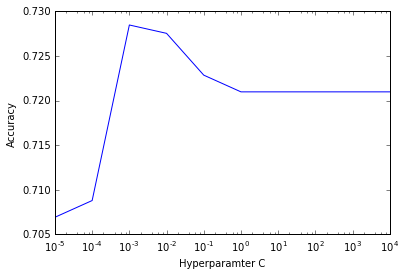

In [229]:
# C=0.001 has the highest accuracy
plt.plot(params, score)
plt.xscale('log')
plt.xlabel('Hyperparamter C')
plt.ylabel('Accuracy')

In [252]:
result = dict(zip(params, score))

In [259]:
pprint('The best C is {} and the best accuracy score is {}'.format(max(result, key=lambda k: result[k]), max(result.values())))

'The best C is 0.001 and the best accuracy score is 0.728464419476'


# 2. SVM

In [260]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, probability=True, random_state=1)

In [261]:
svm.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False)

In [262]:
y_pred = svm.predict(X_test_std)

In [263]:
accuracy_score(y_test, y_pred)

0.72940074906367036

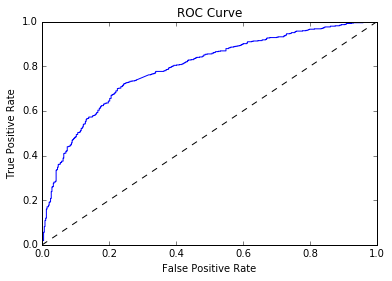

In [58]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = svm.predict_proba(X_test_std)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

### look for hyperparameter C for SVM by for loop

In [264]:
params, score = [], []
for c in np.arange(-1, 4):
    clf = SVC(kernel='linear', C=10.**c, random_state=1)
    clf.fit(X_train_std, y_train)
    predict = clf.predict(X_test_std)
    score.append(accuracy_score(y_test, predict))
    params.append(10.**c)

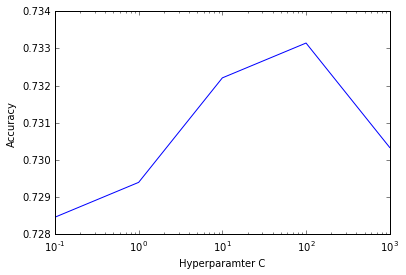

In [265]:
# C=100 has the highest accuracy
plt.plot(params, score)
plt.xscale('log')
plt.xlabel('Hyperparamter C')
plt.ylabel('Accuracy')

In [266]:
result = dict(zip(params, score))

In [269]:
print 'The best C for SVM is {} and accuracy score is {}'.format(max(result, key= lambda k: result[k]), max(result.values()))

The best C for SVM is 100.0 and accuracy score is 0.733146067416


### GridSearch CV

In [96]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c = np.logspace(-5, 3, 10)
param_grid = {'C': c}

# Instantiate a logistic regression classifier: logreg
svm = SVC(kernel='linear', random_state=1)

# Instantiate the GridSearchCV object: logreg_cv
svm_cv = GridSearchCV(svm, param_grid, cv=5)

# Fit it to the data
svm_cv.fit(X_train_std, y_train)

# Print the tuned parameters and score (TYPO ALERT!!! it should be svm instead of svm_rbf)
print("Tuned svm_rbf Parameters: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))

Tuned svm_rbf Parameters: {'C': 2.154434690031882}
Best score is 0.71176234444


In [270]:
# test hold-out data
print 'The best C from SVM grid search is {} and the accuracy score is {}'.format(2.1544, accuracy_score(y_test, svm_cv.predict(X_test_std)))

The best C from SVM grid search is 2.1544 and the accuracy score is 0.730337078652


# 3. Kernel SVM 

In [89]:
from sklearn.svm import SVC
svm_rbf = SVC(kernel='rbf', gamma = 0.1, C=1.0, random_state=1)
svm_rbf.fit(X_train_std, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [90]:
print accuracy_score(y_train, svm_rbf.predict(X_train_std)), accuracy_score(y_test, svm_rbf.predict(X_test_std))

0.936571657969 0.695692883895


### look for the best gamma and C in kernel SVM 

In [94]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
r = np.logspace(-5, 2, 10)
c = np.logspace(-5, 2, 10)
param_grid = {'gamma': 10.**r, 'C': 10.**c}

# Instantiate a logistic regression classifier: logreg
svm_rbf = SVC(kernel='rbf', random_state=1)

# Instantiate the GridSearchCV object: logreg_cv
svm_rbf_cv = GridSearchCV(svm_rbf, param_grid, cv=5)

# Fit it to the data
svm_rbf_cv.fit(X_train_std, y_train)

# Print the tuned parameters and score
print("Tuned svm_rbf Parameters: {}".format(svm_rbf_cv.best_params_)) 
print("Best score is {}".format(svm_rbf_cv.best_score_))

Tuned svm_rbf Parameters: {'C': 1.0301856513773824, 'gamma': 1.0000230261160268}
Best score is 0.56322761943


In [271]:
# test hold-out data
print 'The best gamma is {} and the best C is {}. The accuracy score is {}'.format(1, 1, accuracy_score(y_test, svm_rbf_cv.predict(X_test_std)))

The best gamma is 1 and the best C is 1. The accuracy score is 0.567415730337


# 4. KNN

In [272]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [273]:
print accuracy_score(y_train, knn.predict(X_train_std)), accuracy_score(y_test, knn.predict(X_test_std))

0.765154556403 0.65074906367


### look for best K with KNN (Euclidean)

In [274]:
train_score = []
test_score = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    knn.fit(X_train_std, y_train)
    predict1 = knn.predict(X_train_std)
    score1 = accuracy_score(y_train, predict1)
    train_score.append(score1)
    predict2 = knn.predict(X_test_std)
    score2 = accuracy_score(y_test, predict2)
    test_score.append(score2)

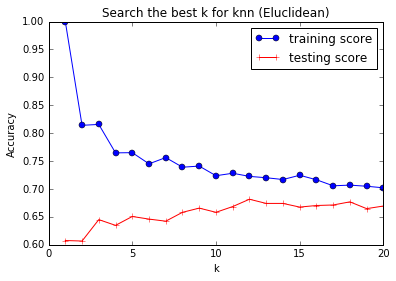

In [276]:
k_range = range(1, 21)
plt.plot(k_range, train_score, marker='o', label='training score')
plt.plot(k_range, test_score, marker='+', color='red', label='testing score')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Search the best k for knn (Eluclidean)')
plt.legend()

In [278]:
result= dict(zip(k_range, test_score))

In [279]:
print 'The best K is {} and the accuracy score is {}'.format(max(result, key=lambda k: result[k]),max(test_score))

The best K is 12 and the accuracy score is 0.681647940075


### look for the best K with KNN (Manhattan)

In [291]:
train_score = []
test_score = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)
    knn.fit(X_train_std, y_train)
    predict1 = knn.predict(X_train_std)
    score1 = accuracy_score(y_train, predict1)
    train_score.append(score1)
    predict2 = knn.predict(X_test_std)
    score2 = accuracy_score(y_test, predict2)
    test_score.append(score2)

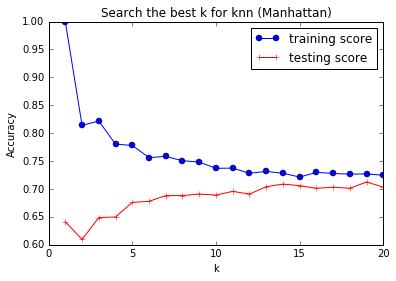

In [292]:
k_range = range(1, 21)
plt.plot(k_range, train_score, marker='o', label='training score')
plt.plot(k_range, test_score, marker='+', color='red', label='testing score')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Search the best k for knn (Manhattan)')
plt.legend()

In [293]:
result= dict(zip(k_range, test_score))

In [294]:
print 'The best K is {} and the accuracy score is {}'.format(max(result, key=lambda k: result[k]),max(test_score))

The best K is 19 and the accuracy score is 0.712546816479


# 5. Decision tree

In [284]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [285]:
print accuracy_score(y_train, tree.predict(X_train_std)), accuracy_score(y_test, tree.predict(X_test_std))

0.693295865114 0.681647940075


### look for the best max_depth with tree

In [286]:
depth = range(1, 21)
train_score = []
test_score = []
for t in depth:
    tree = DecisionTreeClassifier(criterion='gini', max_depth=t, random_state=1)
    tree.fit(X_train_std, y_train)
    predict1 = tree.predict(X_train_std)
    score1 = accuracy_score(y_train, predict1)
    train_score.append(score1)
    predict2 = tree.predict(X_test_std)
    score2 = accuracy_score(y_test, predict2)
    test_score.append(score2)

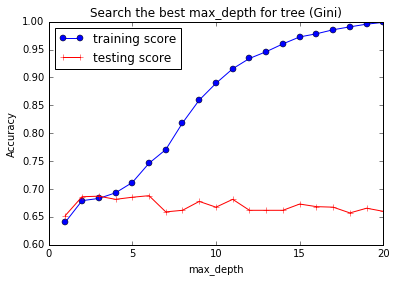

In [287]:
plt.plot(depth, train_score, marker='o', label='training score')
plt.plot(depth, test_score, marker='+', color='red', label='testing score')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Search the best max_depth for tree (Gini)')
plt.legend(loc=2)

In [289]:
result=dict(zip(depth, test_score))

In [290]:
print 'The best max_depth is {} and the accuracy score is {}'.format(max(result, key=lambda k: result[k]),max(test_score))

The best max_depth is 6 and the accuracy score is 0.688202247191


# 6. Random Forest

In [295]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1)
forest.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [296]:
print accuracy_score(y_train, forest.predict(X_train_std)), accuracy_score(y_test, forest.predict(X_test_std))

0.998394219189 0.714419475655


### look for the best n_estimators

In [297]:
num = np.arange(5, 105, 5)
train_score = []
test_score = []
for i in num:
    forest = RandomForestClassifier(criterion='gini', n_estimators=i, random_state=1)
    forest.fit(X_train_std, y_train)
    predict1 = forest.predict(X_train_std)
    score1 = accuracy_score(y_train, predict1)
    train_score.append(score1)
    predict2 = forest.predict(X_test_std)
    score2 = accuracy_score(y_test, predict2)
    test_score.append(score2)

(0.65, 1.05)

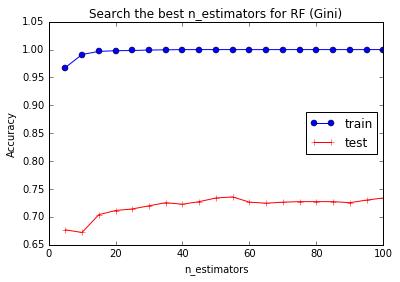

In [298]:
plt.plot(num, train_score, marker='o', label='train')
plt.plot(num, test_score, marker='+', color='red', label='test')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Search the best n_estimators for RF (Gini)')
plt.legend(loc=7)
plt.ylim(0.65, 1.05)

In [299]:
result=dict(zip(num, test_score))
print 'The best n_estimator is {} and the accuracy score is {}'.format(max(result, key=lambda k: result[k]),max(test_score))

The best n_estimator is 55 and the accuracy score is 0.73595505618


### RandomizedSearchCV

In [185]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [186]:
forest = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_std, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.7min finished


[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=30 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=30 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_features=sqrt, max_depth=30 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, max_depth=10 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, max_depth=10 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, min_samples_split=5, max_features=sqrt, max_depth=10 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1200, min_samples_split=5, max_features=sqrt, max_depth=10 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1200, min_samples_split=5, max_features=sqrt, max_depth=10 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=400, min_samples_split=5, max_feat

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)




[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=2000, min_samples_split=10, max_features=auto, max_depth=100, total=  22.7s



[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1000, min_samples_split=5, max_features=sqrt, max_depth=20 
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=800, min_samples_split=10, max_features=sqrt, max_depth=50 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=800, min_samples_split=2, max_features=sqrt, max_depth=50 

[CV] bootstrap=False, min_samples_leaf=1, n_estimators=400, min_samples_split=2, max_features=sqrt, max_depth=None 
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=1200, min_samples_split=10, max_features=sqrt, max_depth=20 
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=800, min_samples_split=5, max_features=sqrt, max_depth=100 
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=800, min_samples_split=10, max_features=sqrt, max_depth=50 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=100

In [302]:
best = rf_random.best_params_

In [303]:
print 'The best parametmers are {} and the accuracy is {}'.format(best, accuracy_score(y_test, rf_random.predict(X_test_std)))

The best parametmers are {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 400, 'max_features': 'sqrt', 'min_samples_split': 5, 'max_depth': 100} and the accuracy is 0.737827715356


### GridCV Search

In [202]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300, 400, 500, 600]
}
# Create a based modela
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [203]:
grid_search.fit(X_train_std, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  4.6min finished


[CV] bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=200, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=200, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=200, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=300, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=300, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=sqrt, min_samples_split

AttributeError: 'GridSearchCV' object has no attribute 'best_param_'









[CV] bootstrap=True, min_samples_leaf=2, n_estimators=400, max_features=sqrt, min_samples_split=10, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=100, max_features=sqrt, min_samples_split=10, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=200, max_features=sqrt, min_samples_split=5, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=600, max_features=sqrt, min_samples_split=10, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=3, n_estimators=400, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=300, max_features=sqrt, min_samples_split=2, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=100, max_features=sqrt, min_samples_split=10, max_depth=80 
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=500, max_features=sqrt, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=400, max_features=sqrt, min_

In [304]:
best = grid_search.best_params_

In [305]:
print 'The best parametmers are {} and the accuracy is {}'.format(best, accuracy_score(y_test, grid_search.predict(X_test_std)))

The best parametmers are {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 100} and the accuracy is 0.736891385768


# --------------------------